In [1]:
import os
import numpy as np
import pandas as pd
import math

import tensorflow as tf
# from keras.models import Model, load_model
# from keras.utils import CustomObjectScope
# from keras.initializers import glorot_uniform
# from keras.layers import Input, Dense, Conv2D, Flatten, Concatenate
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Convolution2D, Flatten, Concatenate, MaxPooling2D, Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


from contextlib import redirect_stdout
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

Using TensorFlow backend.


# Model Template for amliNet :)

In [0]:
#!unzip -q "/content/drive/My Drive/The Cool Kids/Data/CheXpert-v1.0-small.zip"

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

## Global Variables

In [3]:
outcomes = ['No Finding',
            'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
            'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
            'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
            'Support Devices']
pathologies = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
            'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
            'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
            'Support Devices']

PATH = '/content/CheXpert-v1.0-small'
target = pathologies

image_size = 256
train_batch_size = 64
val_batch_size = 64
test_batch_size = 234

#train_set_size =len(train_df)

lr = 0.0001 #learning rate
num_steps_per_epoch = 2500 #can be set to none for auto choosing
num_epochs = 3

threshold = 0.5

#create the directory before you start!
model_name = 'multi_label_overnight'
model_directory = model_name+'/' 
if os.path.isdir(model_directory):
    print('Did you mean to rename the model?')
else:
    os.makedirs(model_directory)

Did you mean to rename the model?


### Save the hyperparameters used

## Preprocessing

In [0]:
def edit_urls(url):
    ''' a function to edit the urls to the correct path using a global PATH variable declared earlier
    '''
    pieces = url.split('/')
    newurl = ''

      #removing the previous path 'CheXpert-v1.0-small' and including the PATH
    for i, piece in enumerate(pieces):
        if i > 0:
            newurl+= '/' + piece
        elif i == 0:
            newurl += PATH

    return newurl

def clean_data(df):
    '''
    Edits the urls, fills the 'maybes' with yes and the nulls with no,
    removes outlier ages (age 0 patients), removes 'unknown gender' patients,
    collects which type of image it is
    '''
    df['Path'] = df['Path'].apply(edit_urls)
    df[outcomes] = df[outcomes].fillna(0)
    df[outcomes] = df[outcomes].replace(-1,1)
    return df


In [5]:
train_df = clean_data(pd.read_csv(PATH + '/train.csv'))
test_df = clean_data(pd.read_csv(PATH + '/valid.csv'))
num_test_df = test_df[pathologies]
#train_df[outcomes].head()
#can chose a subset here
#train_df = train_df.sample(train_set_size)

#for keras, make the target a string
train_df[pathologies] = train_df[pathologies].astype(str)

test_df[pathologies] = test_df[pathologies].astype(str)

print('test set:', test_df.shape)
print('training set:', train_df.shape)

test set: (234, 19)
training set: (223414, 19)


## Prepare the Model

In [7]:
datagen = ImageDataGenerator(
   rescale = 1./255,
   validation_split = 0.2
)

train_generator = datagen.flow_from_dataframe(
   train_df,
   x_col='Path',
   y_col=pathologies,
   color_mode='grayscale', # images will be converted to have 1 color channel
   target_size=(image_size, image_size), #The dimensions to which all images found will be resized
   class_mode='other', # Mode for yielding the targets 1D numpy array of binary labels,if class_mode is "binary" it must include the given y_col column with class values as strings.
   batch_size=train_batch_size,
   subset = "training"
   #shuffle: whether to shuffle the data (default: True)
)

validation_generator = datagen.flow_from_dataframe(
   train_df,
   x_col='Path',
   y_col=pathologies,
   target_size=(image_size, image_size),
   color_mode='grayscale',
   class_mode='other',
   batch_size=val_batch_size,
   subset = "validation"
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='Path',
    y_col=pathologies,
    target_size=(image_size, image_size),
    color_mode='grayscale',
    class_mode=None,
    batch_size=test_batch_size,
    shuffle = False #just in case
)

Found 178732 validated image filenames.
Found 44682 validated image filenames.
Found 234 validated image filenames.


## Edit your model here

### To create a model

In [0]:
#We create a Sequential model using 'categorical cross-entropy' as our loss function and 'adam' as the optimizer.

from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers



model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(256,256,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(13, activation='sigmoid'))


model.compile(optimizers.adam(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])

## Save model summary and set checkpoints

In [0]:
with open(model_directory + 'model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

checkpoints_path = model_directory + "checkpoints/checkpoint-epoch{epoch:02d}-val_acc{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(checkpoints_path,  
                             monitor = 'val_acc',
                             verbose=0, 
                             save_best_only=False, 
                             save_weights_only=False, 
                             mode='auto'
                            )

## Run the model

### Train the model

(only necessary when you are creating a model, not loading a model)

In [11]:
# uses some global variables
history = model.fit_generator(train_generator,
                              steps_per_epoch = num_steps_per_epoch, 
                              epochs = 30,
                              validation_data = validation_generator,
                              #callbacks = [checkpoint],
                              validation_steps=10)

Epoch 1/30
2500/2500 [==============================] - 1002s 401ms/step - loss: 0.4101 - acc: 0.8163 - val_loss: 0.3992 - val_acc: 0.8278
Epoch 2/30
2500/2500 [==============================] - 1000s 400ms/step - loss: 0.4017 - acc: 0.8207 - val_loss: 0.4101 - val_acc: 0.8206
Epoch 3/30
2500/2500 [==============================] - 1000s 400ms/step - loss: 0.3942 - acc: 0.8244 - val_loss: 0.3941 - val_acc: 0.8256
Epoch 4/30
2500/2500 [==============================] - 1001s 400ms/step - loss: 0.3851 - acc: 0.8291 - val_loss: 0.3957 - val_acc: 0.8261
Epoch 5/30
2500/2500 [==============================] - 1001s 401ms/step - loss: 0.3758 - acc: 0.8330 - val_loss: 0.3862 - val_acc: 0.8365
Epoch 6/30
2500/2500 [==============================] - 1003s 401ms/step - loss: 0.3639 - acc: 0.8384 - val_loss: 0.3927 - val_acc: 0.8274
Epoch 7/30
2500/2500 [==============================] - 1002s 401ms/step - loss: 0.3497 - acc: 0.8446 - val_loss: 0.4000 - val_acc: 0.8332
Epoch 8/30
2500/2500 [=====

## Save the model

In [12]:
model.save(model_directory + model_name + '.h5')

print('Model saved in', model_directory)

Model saved in multi_label_overnight/


### Make Predictions

(be patient)

In [13]:
predictions = model.predict_generator(test_generator, steps = len(test_generator))
print(f'made {len(predictions)} predictions')

#test predictions
# a = predictions[0].round(2)
# print(a)

made 234 predictions


In [0]:
#test actual dataframe
#num_test_df.head()

In [15]:
#get predictions >0.5 and print prediction table
pred_bool = (predictions >0.5)
predictions = pred_bool.astype(int)
print(type(predictions))
pathologies = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
            'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
            'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
            'Support Devices']

#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=pathologies)
results["Filenames"]=test_generator.filenames
ordered_cols=["Filenames"]+pathologies
results=results[ordered_cols]#To get the same column order
results

<class 'numpy.ndarray'>


,Filenames,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,/content/CheXpert-v1.0-small/valid/patient6454...,0,0,0,0,0,0,0,0,0,0,0,0,1
1,/content/CheXpert-v1.0-small/valid/patient6454...,0,0,0,0,0,0,0,0,0,0,0,0,0
2,/content/CheXpert-v1.0-small/valid/patient6454...,0,0,0,0,0,0,0,0,0,0,0,0,0
3,/content/CheXpert-v1.0-small/valid/patient6454...,0,0,1,0,1,0,0,0,0,1,0,0,1
4,/content/CheXpert-v1.0-small/valid/patient6454...,0,0,0,0,0,0,0,0,0,0,0,0,0
5,/content/CheXpert-v1.0-small/valid/patient6454...,0,0,0,0,0,1,0,1,0,1,0,0,1
6,/content/CheXpert-v1.0-small/valid/patient6454...,0,0,1,0,0,0,0,0,0,1,0,0,1
7,/content/CheXpert-v1.0-small/valid/patient6454...,0,0,0,0,0,0,0,0,0,0,0,0,0
8,/content/CheXpert-v1.0-small/valid/patient6454...,0,0,0,0,0,0,0,0,0,0,0,0,0
9,/content/CheXpert-v1.0-small/valid/patient6454...,0,0,1,0,0,0,0,0,0,0,0,0,0


In [16]:
#another way to compare predictions and actuals

print(predictions[:4])
actual_values = np.array(num_test_df)
actual_values = actual_values.astype(int)
print(actual_values[:4])

[[0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 1 0 0 1]]
[[1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 1 0 1 0 0 0 0 0 0 0 0]]


## History of the model

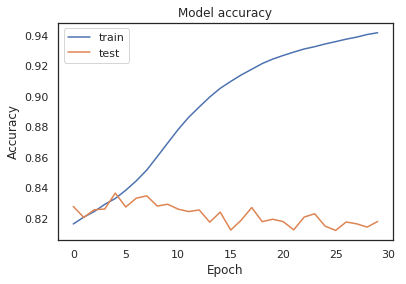

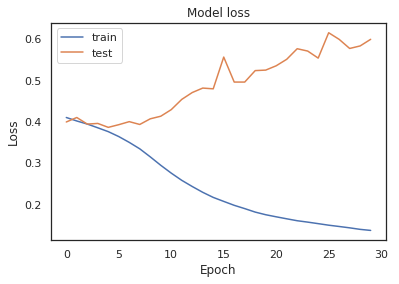

In [17]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Do metrics

In [18]:
# confusion metrics


from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import average_precision_score

multilabel_confusion_matrix(predictions, actual_values)
#average_precision_score(actual_values, predictions) 
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
#https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff


# display_conf_mat(probability_sick, actual_labels, threshold)
# get_roc_curve(probability_sick, actual_labels)
# get_precision_recall_curve(probability_sick, actual_labels)

array([[[124, 109],
        [  1,   0]],

       [[161,  60],
        [  5,   8]],

       [[ 84,  50],
        [ 24,  76]],

       [[233,   1],
        [  0,   0]],

       [[168,  16],
        [ 21,  29]],

       [[189,  26],
        [ 12,   7]],

       [[221,   7],
        [  5,   1]],

       [[131,  57],
        [ 23,  23]],

       [[221,   8],
        [  5,   0]],

       [[138,  31],
        [ 29,  36]],

       [[233,   1],
        [  0,   0]],

       [[233,   0],
        [  1,   0]],

       [[ 89,  45],
        [ 38,  62]]])